# Prediction
Explanation:

## Import Packages

In [106]:
from importnb import Notebook
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.metrics import ConfusionMatrixDisplay

## Dataframe import from 'FeatureEngineering'

In [107]:
pd.set_option('display.max_columns', None)

In [108]:
with Notebook():
    from FeatureEngineering import companies

In [109]:
companies

,ID,Organization Name,Industries,Description,CB Rank (Company),Founded Date,Exit Date,Website,Twitter,Facebook,LinkedIn,Full Description,Industry Groups,Number of Founders,Number of Employees,Founders,Number of Funding Rounds,Last Funding Date,Last Funding Amount,Total Funding Amount (in USD),Top 5 Investors,Number of Lead Investors,Number of Investors,Number of Acquisitions,Acquired by,Announced Date Acquisition,IPO,Months until First Round,Grant Y/N,Last Round Type,Was Acquired,Made Acquisitions,Project Funding,Startup Funding,Growth Funding,Expansion Funding,Exit Funding,HighFunding,Average Time To Next Round,Average Funding Size,Company ID,Average Number of Investments by Investors,Average Number of Exits by Investors,Average Number of Lead Investments by Investors,Average Number of Portfolio Organizations by Investors,Investor Country_AUS,Investor Country_GER,Investor Country_SWI,Investor Country_UK,Investor Country_USA,Top Investor Participation,Months between Founding and Acquisition,Industry_administrative services,Industry_advertising,Industry_agriculture and farming,Industry_apps,Industry_artificial intelligence (ai),Industry_biotechnology,Industry_blockchain and cryptocurrency,Industry_clothing and apparel,Industry_commerce and shopping,Industry_community and lifestyle,Industry_consumer electronics,Industry_consumer goods,Industry_content and publishing,Industry_data and analytics,Industry_design,Industry_education,Industry_energy,Industry_events,Industry_financial services,Industry_food and beverage,Industry_gaming,Industry_government and military,Industry_hardware,Industry_health care,Industry_information technology,Industry_internet services,Industry_lending and investments,Industry_manufacturing,Industry_media and entertainment,Industry_messaging and telecommunications,Industry_mobile,Industry_music and audio,Industry_natural resources,Industry_navigation and mapping,Industry_other,Industry_payments,Industry_platforms,Industry_privacy and security,Industry_professional services,Industry_real estate,Industry_sales and marketing,Industry_science and engineering,Industry_social impact,Industry_software,Industry_sports,Industry_sustainability,Industry_transportation,Industry_travel and tourism,Industry_video,Success
0,000001,Axino Solutions,"[Computer, Software]",Axino Solutions is an innovative software and ...,"2,266,795",2016-01-01,2021-04-06,http://www.axino-group.com,https://twitter.com/axinosolutions,https://www.facebook.com/Axino-Solutions-29835...,https://www.linkedin.com/company/axino-solutio...,Axino Solutions is an innovative software and ...,"[Consumer Electronics, Hardware, Software]",2.555556,175.5,NaN,2,2022-08-18,NaN,NaN,"Technology Fund, Momenta",2.0,2.0,0.0,Axians IT Business Solutions GmbH,2021-04-06,0,62.0,0,Seed,1,0,1,1,0,0,0,0,62.933333,0.000000e+00,000001,71.000000,8.000000,35.000000,56.0,0.0,0.0,1.0,0.0,0.0,0,64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
1,000002,cellEQ,[Professional Services],"CellEQ develops, produces and distributes indi...","200,169",2018-01-01,NaT,https://celleq.de,NaN,NaN,https://www.linkedin.com/company/celleq-gmbh,"CellEQ develops, produces and distributes indi...",[Other],2.000000,5.5,"Florian Kessler, Phillip Nicolas Wagner",1,2018-01-01,30000.0,30000.0,EXIST,0.0,1.0,0.0,NaN,NaT,0,0.0,0,Pre-Seed,0,0,1,0,0,0,0,0,0.000000,3.000000e+04,000002,54.000000,2.000000,15.000000,52.0,0.0,1.0,0.0,0.0,0.0,0,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,000003,Clinomic,"[Artificial Intelligence (AI), Biotechnology, ...",Medical AI company with a focus on critical care.,"27,155",2019-01-14,NaT,https://clinomic.ai,https://twitter.com/clinomicai,https://www.facebook.com/Clinom

### Success Definition

In [110]:
# Load companies dataset
data = companies

# Create 'Success' target variable
data['Success'] = ((data['Was Acquired'] == 1) | 
                   (data['IPO'] == 1) | 
                   (data['HighFunding'] == 1)).astype(int)

# Balance target variable
data['Success'].value_counts(normalize=True) * 100


Success
0    82.516556
1    17.483444
Name: proportion, dtype: float64

### Data Preparation

In [111]:
# Remove non-numeric columns
data = data.select_dtypes(include=[np.number])

# Drop rows with missing values
data = data.dropna()

# Correlation Analysis
correlation_matrix = data.corr()

# Correlation
feature_correlation_matrix = data.drop(columns=['Success']).corr()
upper_triangle = feature_correlation_matrix.where(np.triu(np.ones(feature_correlation_matrix.shape), k=1).astype(bool))
highly_correlated_features = [
    (feature_correlation_matrix.columns[col], feature_correlation_matrix.index[row], upper_triangle.iloc[row, col])
    for row in range(upper_triangle.shape[0])
    for col in range(row + 1, upper_triangle.shape[1])
    if abs(upper_triangle.iloc[row, col]) > 0.8
]

# Print highly correlated features
if highly_correlated_features:
    print("highly correlated features:")
    for feature1, feature2, correlation in highly_correlated_features:
        print(f"{feature1} and {feature2} with a correlation of {correlation:.2f}")
else:
    print("no highly correlated features.")

# Drop unnecessary columns 
columns_to_drop = ['Was Acquired', 'IPO', 'HighFunding'         # Already included in target
                   ,'Months between Founding and Acquisition']  # Highl correlated with 'Was Acquired'
data = data.drop(columns=columns_to_drop)

Stark korrelierte Feature-Paare:
Average Funding Size und Last Funding Amount mit einer Korrelation von 0.91
Average Time To Next Round und Months until First Round mit einer Korrelation von 0.87
Months between Founding and Acquisition und Was Acquired mit einer Korrelation von 0.94
Average Number of Portfolio Organizations by Investors und Average Number of Investments by Investors mit einer Korrelation von 0.94
Industry_data and analytics und Industry_artificial intelligence (ai) mit einer Korrelation von 0.85


### Train-Test Split

In [112]:
# Splitting data into features and target
X = data.drop(columns=['Success'])
y = data['Success']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE on the training data, because of the imbalanced target variable (see above)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

### Models

In [113]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train_resampled)
rf_predictions = rf_model.predict(X_test_scaled)
rf_report = classification_report(y_test, rf_predictions)

# Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_scaled, y_train_resampled)
gb_predictions = gb_model.predict(X_test_scaled)
gb_report = classification_report(y_test, gb_predictions)

# LightGBM
lgb_train = lgb.Dataset(X_train_scaled, y_train_resampled)
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train_scaled, y_train_resampled)
lgb_predictions = lgb_model.predict(X_test_scaled)
lgb_report = classification_report(y_test, lgb_predictions)

[LightGBM] [Info] Number of positive: 474, number of negative: 474
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3864
[LightGBM] [Info] Number of data points in the train set: 948, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


### Results

               Model  Accuracy  Precision    Recall  F1-Score       AUC
0      Random Forest  0.841060   0.775018  0.704963  0.729391  0.839023
1  Gradient Boosting  0.841060   0.764518  0.739233  0.750413  0.848214
2           LightGBM  0.860927   0.819414  0.728992  0.759718  0.832195


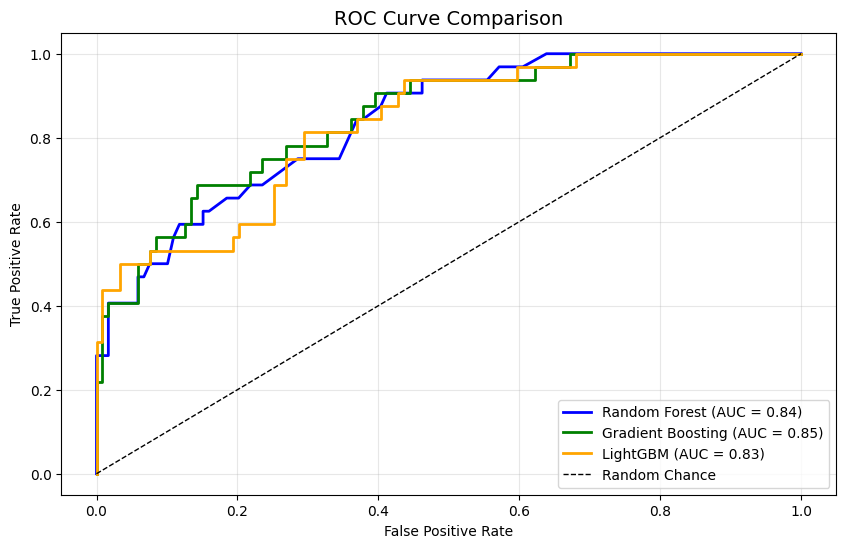

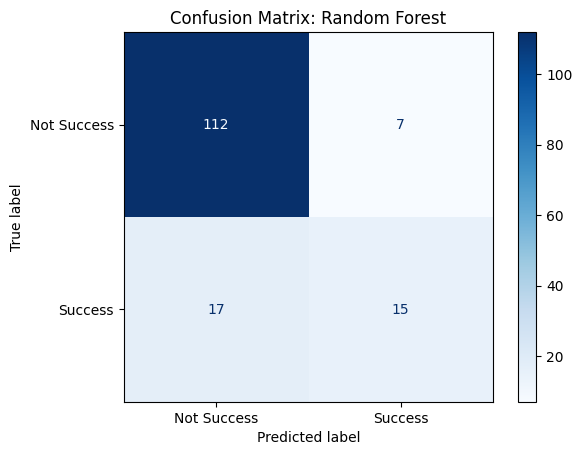

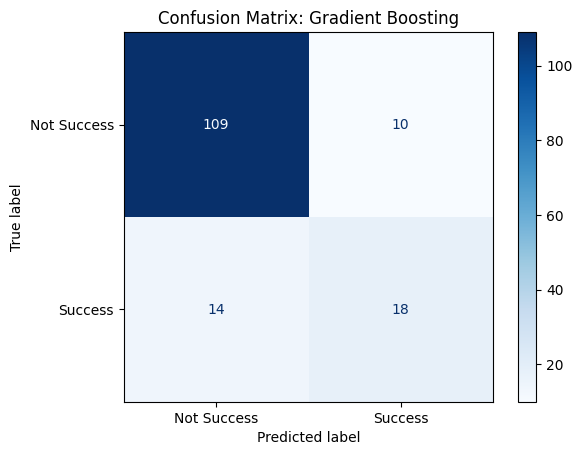

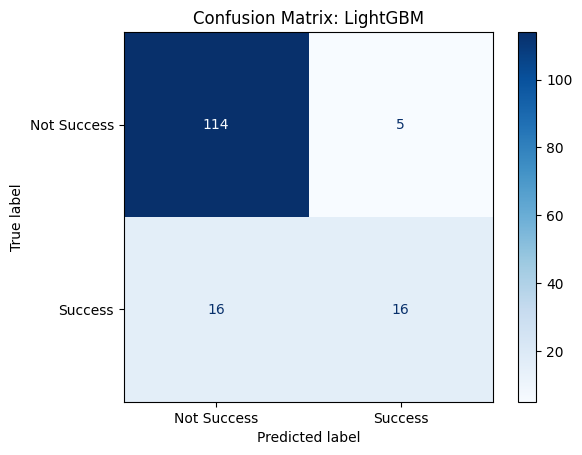

In [114]:
# Results Summary
rf_report = classification_report(y_test, rf_model.predict(X_test_scaled), output_dict=True)
gb_report = classification_report(y_test, gb_model.predict(X_test_scaled), output_dict=True)
lgb_report = classification_report(y_test, lgb_model.predict(X_test_scaled), output_dict=True)

results = {
    "Model": ["Random Forest", "Gradient Boosting", "LightGBM"],
    "Accuracy": [
        rf_report['accuracy'],
        gb_report['accuracy'],
        lgb_report['accuracy']
    ],
    "Precision": [
        rf_report['macro avg']['precision'],
        gb_report['macro avg']['precision'],
        lgb_report['macro avg']['precision']
    ],
    "Recall": [
        rf_report['macro avg']['recall'],
        gb_report['macro avg']['recall'],
        lgb_report['macro avg']['recall']
    ],
    "F1-Score": [
        rf_report['macro avg']['f1-score'],
        gb_report['macro avg']['f1-score'],
        lgb_report['macro avg']['f1-score']
    ],
    "AUC": [
        roc_auc_score(y_test, rf_model.predict_proba(X_test_scaled)[:, 1]),
        roc_auc_score(y_test, gb_model.predict_proba(X_test_scaled)[:, 1]),
        roc_auc_score(y_test, lgb_model.predict_proba(X_test_scaled)[:, 1])
    ]
}

results_df = pd.DataFrame(results)
print(results_df)


# Plotting ROC Curve
plt.figure(figsize=(10, 6))
for model, name, color in zip([rf_model, gb_model, lgb_model], 
                              ["Random Forest", "Gradient Boosting", "LightGBM"], 
                              ["blue", "green", "orange"]):
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})', linewidth=2, color=color)

# Add Baseline 
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison', fontsize=14)
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

for model, name in zip([rf_model, gb_model, lgb_model], ["Random Forest", "Gradient Boosting", "LightGBM"]):
    disp = ConfusionMatrixDisplay.from_estimator(model, X_test_scaled, y_test, cmap='Blues', display_labels=["Not Success", "Success"])
    plt.title(f'Confusion Matrix: {name}')
    plt.show()

### Feature Importance

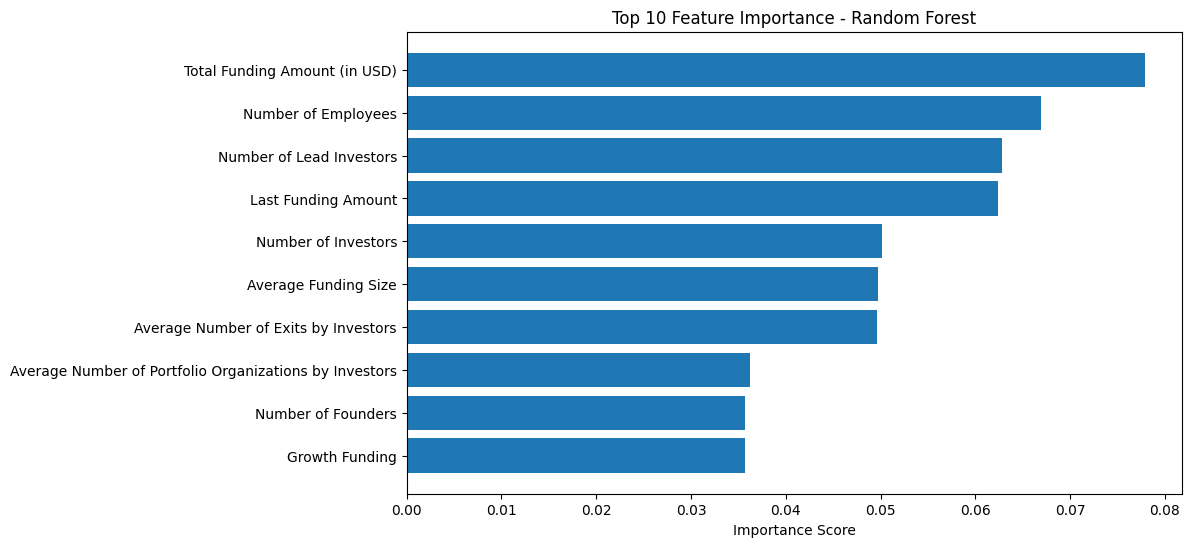

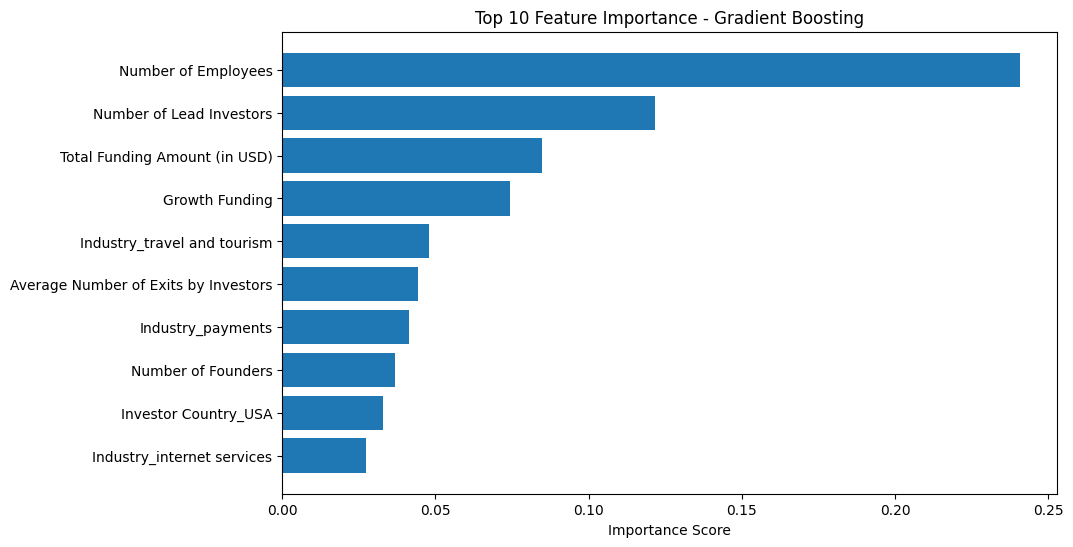

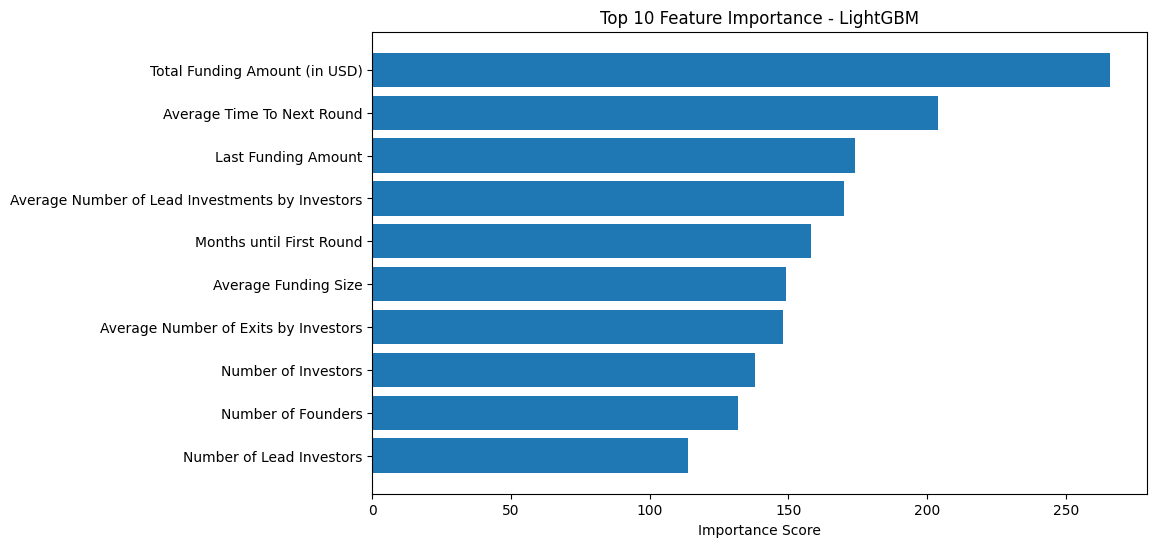

In [115]:
# Feature Importance Visualization (Top 10 Features)
def plot_top_feature_importance(model, feature_names, model_name, top_n=10):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'feature_importance_'):
        importances = model.feature_importance_()
    else:
        print(f"{model_name} does not support feature importance.")
        return
    
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(top_n)
    
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
    plt.title(f'Top {top_n} Feature Importance - {model_name}')
    plt.xlabel('Importance Score')
    plt.show()

# Plot top 10 feature importance for each model
feature_names = X.columns
plot_top_feature_importance(rf_model, feature_names, "Random Forest")
plot_top_feature_importance(gb_model, feature_names, "Gradient Boosting")
plot_top_feature_importance(lgb_model, feature_names, "LightGBM")